In [79]:
import numpy as np
import pandas as pd
import tokenizers
from tqdm import tqdm
from tokenizers import pre_tokenizers
from torch.utils.data import Dataset,DataLoader
import tokenizers.trainers
from transformers import PreTrainedTokenizerFast
from tokenizers import Tokenizer
import pyperclip
import re
from torch.distributions import Categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.utils.class_weight import compute_class_weight
from seaborn import heatmap
import torch.nn as nn
import torch

In [6]:
main_data = pd.read_csv('/home/luchian/all_data/uni_data/corona.csv',usecols=['OriginalTweet','Sentiment'])
main_data

,OriginalTweet,Sentiment
0,"Guess?, Inc. Provides COVID-19 Business Update...",Positive
1,So much panic-bought food fresh food will neve...,Positive
2,Instead of giving financial aid that is close ...,Positive
3,WAIT A DAMN MINUTE\r\r\n\r\r\nso Amazon worker...,Positive
4,Pig prices were up this week at 163 39p kg amp...,Extremely Positive
...,...,...
9995,???https://t.co/Ljh5cmUkMPÂ via @amazon ???ht...,Extremely Positive
9996,P Stuck inside Our pals at have slashed prices...,Positive
9997,If you think you may experience financial hard...,Positive
9998,"No toilet paper I can handle, no pasta, ok...b...",Extremely Negative


In [7]:
label_encoder = LabelEncoder().fit(main_data['Sentiment'])
label_encoder.classes_

array(['Extremely Negative', 'Extremely Positive', 'Negative', 'Neutral',
       'Positive'], dtype=object)

In [8]:
main_data['Sentiment'] = label_encoder.transform(main_data['Sentiment'])

In [9]:
main_data.head(5)

,OriginalTweet,Sentiment
0,"Guess?, Inc. Provides COVID-19 Business Update...",4
1,So much panic-bought food fresh food will neve...,4
2,Instead of giving financial aid that is close ...,4
3,WAIT A DAMN MINUTE\r\r\n\r\r\nso Amazon worker...,4
4,Pig prices were up this week at 163 39p kg amp...,1


In [13]:
Train,Test = train_test_split(main_data,train_size = 0.85,stratify = main_data['Sentiment'])

In [14]:
Train.head(5)

,OriginalTweet,Sentiment
5928,@mccrory @Costco MyPOV: pretty much. well it's...,1
5959,If you want to learn about the impact of COVID...,4
2323,"I'm on New impressionz live, clapping for can ...",3
146,The US Attorney's Office has released an offic...,0
2920,Be aware that Scamming activity increases duri...,4


In [15]:
Test.head(5)

,OriginalTweet,Sentiment
7447,The US is asking other countries for everythin...,4
7825,Really @Bell @Bell_Support people are losing j...,4
9057,"moonbeamwishes Hey, Megan! We will work to kee...",4
9359,Maine retail group chief worried about crisis-...,2
9775,"According to a survey by @Path2PurchaseIQ, sho...",3


In [16]:
def proc_text(text):
    lowered = text.lower()
    tokenized = ' '.join(re.findall(r"[A-z0-9]+[A-z0-9]",lowered))
    return tokenized

In [17]:
def train_tokens():
    for row in range(len(Train.iloc[:,0])):
        processed = proc_text(Train.iloc[row,0])
        yield processed

In [18]:
tokenizer = Tokenizer(model = tokenizers.models.WordLevel(unk_token='<unk>'))
tokenizer.pre_tokenizer = tokenizers.pre_tokenizers.Whitespace()
tok_trainer = tokenizers.trainers.WordLevelTrainer(vocab_size = 500_000,special_tokens = ['<pad>','<unk>'])
tokenizer.enable_padding(direction='right',pad_id = 0,pad_token='<pad>')
tokenizer.train_from_iterator(train_tokens(),trainer=tok_trainer)
tokenizer.save('./tok_voc')

In [19]:
class TextDataset(Dataset):
    def __init__(self,texts,tok_path,processing,max_len):
        self.texts = texts
        self.tokenizer = PreTrainedTokenizerFast(tokenizer_file = tok_path)
        self.processing = processing
        self.max_length = max_len
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, indx):
        text,label = self.processing(self.texts.iloc[indx,0]),torch.tensor(self.texts.iloc[indx,1].item())
        tokenized_text = self.tokenizer(
            text,
            max_length = self.max_length,
            padding = 'max_length',
            return_tensors='pt',
            truncation=True
        )['input_ids']
        return tokenized_text.squeeze(dim = 0),label

In [20]:
TrainDataset = TextDataset(texts = Train,
                           tok_path='./tok_voc',
                           processing=proc_text,
                           max_len = 70)

In [21]:
TestDataset = TextDataset(texts = Test,
                           tok_path='./tok_voc',
                           processing=proc_text,
                           max_len = 70)

In [214]:
class ClassificationModel(nn.Module):
    def __init__(self,vocab_size,embed_dim,hidden_size,bi = True,bf = True):
        super().__init__()
        self.embed = nn.Embedding(vocab_size,embed_dim,padding_idx=0)
        self.gru = nn.GRU(input_size = embed_dim,hidden_size = hidden_size,bidirectional = bi,batch_first=bf,num_layers=2,dropout=0.5)
        self.linear = nn.Linear(600,5)

    def forward(self,x):
        y = self.embed(x)
        _,y = self.gru(y)
        y = y.transpose(0,1)
        y = y.reshape(y.shape[0],-1)
        y = self.linear(y)
        return y

In [215]:
vocab_size = tokenizer.get_vocab_size()
embedding_dim = 300
my_model = ClassificationModel(vocab_size=vocab_size,
                               embed_dim = embedding_dim,
                               hidden_size=150)

In [216]:
some_sample = next(iter(loader))

In [217]:
my_model(some_sample[0]).shape

torch.Size([54, 5])

In [218]:
def train_model(model,train_loader,epoch,main_optim,main_loss,print_every = 1):
    try:
        train_losses = []
        for ep in range(epoch):
            model.train()
            epoch_losses = []
            for X,y in tqdm(train_loader,desc=f'Going through the loader on epoch #{ep+1}'):
                main_optim.zero_grad()
                y_pred = model(X)
                the_loss = main_loss(y_pred,y)
                the_loss.backward()
                main_optim.step()
                epoch_losses.append(the_loss.item())
            train_losses.append(round(np.array(epoch_losses).mean().item(),5))
            if ep%print_every == 0:
                print(f'Epoch #{ep+1} | Train loss: {train_losses[-1]}',end = '\n\n')
        return train_losses
    except KeyboardInterrupt:
        return train_losses

In [219]:
weights = compute_class_weight(class_weight='balanced',y = Train['Sentiment'],classes=np.array([_ for _ in range(5)]))
weights = torch.from_numpy(weights).to(dtype = torch.float32)
weights

tensor([1.4965, 1.2583, 0.8240, 1.0732, 0.7185])

In [220]:
#train
epoch = 25
batch_size = 54
lr = 0.0005
loader = DataLoader(dataset = TrainDataset,shuffle = True,batch_size = batch_size)
optimizer = torch.optim.Adam(my_model.parameters(),lr = lr,betas=(0.9,0.989))
criterion = nn.CrossEntropyLoss(reduction = 'mean',weight = weights,label_smoothing=0.001)

In [222]:
results = train_model(model = my_model,
                      train_loader = loader,
                      epoch = epoch,
                      main_optim = optimizer,
                      main_loss = criterion
                      )

Going through the loader on epoch #1: 100%|██████████| 158/158 [00:28<00:00,  5.57it/s]


Epoch #1 | Train loss: 1.55646



Going through the loader on epoch #2: 100%|██████████| 158/158 [00:27<00:00,  5.74it/s]


Epoch #2 | Train loss: 1.28497



Going through the loader on epoch #3: 100%|██████████| 158/158 [00:28<00:00,  5.62it/s]


Epoch #3 | Train loss: 1.04236



Going through the loader on epoch #4: 100%|██████████| 158/158 [00:27<00:00,  5.83it/s]


Epoch #4 | Train loss: 0.81879



Going through the loader on epoch #5: 100%|██████████| 158/158 [00:26<00:00,  5.87it/s]


Epoch #5 | Train loss: 0.62574



Going through the loader on epoch #6: 100%|██████████| 158/158 [00:26<00:00,  5.88it/s]


Epoch #6 | Train loss: 0.45525



Going through the loader on epoch #7: 100%|██████████| 158/158 [00:26<00:00,  5.86it/s]


Epoch #7 | Train loss: 0.31571



Going through the loader on epoch #8: 100%|██████████| 158/158 [00:26<00:00,  5.88it/s]


Epoch #8 | Train loss: 0.22203



Going through the loader on epoch #9: 100%|██████████| 158/158 [00:26<00:00,  5.86it/s]


Epoch #9 | Train loss: 0.14911



Going through the loader on epoch #10: 100%|██████████| 158/158 [00:27<00:00,  5.77it/s]


Epoch #10 | Train loss: 0.12094



Going through the loader on epoch #11: 100%|██████████| 158/158 [00:27<00:00,  5.80it/s]


Epoch #11 | Train loss: 0.09225



Going through the loader on epoch #12: 100%|██████████| 158/158 [00:27<00:00,  5.79it/s]


Epoch #12 | Train loss: 0.07568



Going through the loader on epoch #13: 100%|██████████| 158/158 [00:27<00:00,  5.73it/s]


Epoch #13 | Train loss: 0.06341



Going through the loader on epoch #14: 100%|██████████| 158/158 [00:27<00:00,  5.74it/s]


Epoch #14 | Train loss: 0.04744



Going through the loader on epoch #15: 100%|██████████| 158/158 [00:27<00:00,  5.77it/s]


Epoch #15 | Train loss: 0.05378



Going through the loader on epoch #16: 100%|██████████| 158/158 [00:27<00:00,  5.73it/s]


Epoch #16 | Train loss: 0.04551



Going through the loader on epoch #17: 100%|██████████| 158/158 [00:27<00:00,  5.76it/s]


Epoch #17 | Train loss: 0.03366



Going through the loader on epoch #18: 100%|██████████| 158/158 [00:27<00:00,  5.73it/s]


Epoch #18 | Train loss: 0.03523



Going through the loader on epoch #19: 100%|██████████| 158/158 [00:27<00:00,  5.77it/s]


Epoch #19 | Train loss: 0.03699



Going through the loader on epoch #20: 100%|██████████| 158/158 [00:28<00:00,  5.57it/s]


Epoch #20 | Train loss: 0.03395



Going through the loader on epoch #21:  16%|█▋        | 26/158 [00:04<00:24,  5.36it/s]


In [223]:
@torch.no_grad()
def get_preds(model,Val):
    model.eval()
    the_loader = DataLoader(dataset = Val, shuffle = False, batch_size = 1)
    y_true_list = []
    y_pred_list = []
    for X,y in the_loader:
        probs = model(X).softmax(dim = 1)
        distribution = Categorical(probs)
        y_pred = distribution.sample()
        y_true_list.append(y.item())
        y_pred_list.append(y_pred.item())
    return np.array(y_true_list),np.array(y_pred_list)

In [224]:
y_true,y_pred = get_preds(my_model,TestDataset)

In [225]:
report = classification_report(y_true = y_true,y_pred = y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.50      0.60      0.55       201
           1       0.62      0.54      0.58       238
           2       0.40      0.47      0.43       364
           3       0.53      0.52      0.53       280
           4       0.50      0.43      0.46       417

    accuracy                           0.49      1500
   macro avg       0.51      0.51      0.51      1500
weighted avg       0.50      0.49      0.50      1500



<Axes: >

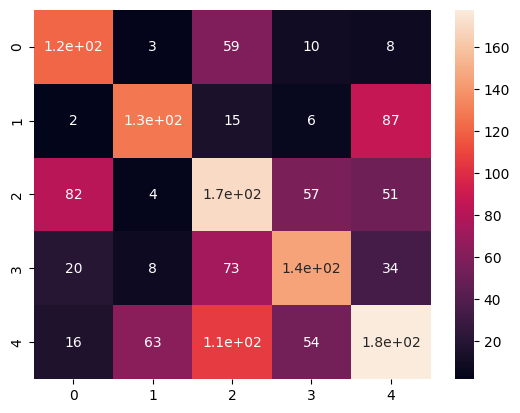

In [226]:
conf_matrix = confusion_matrix(y_true = y_true,y_pred = y_pred)
heatmap(conf_matrix,annot = True)

In [ ]:
label_encoder.classes_

array(['Extremely Negative', 'Extremely Positive', 'Negative', 'Neutral',
       'Positive'], dtype=object)

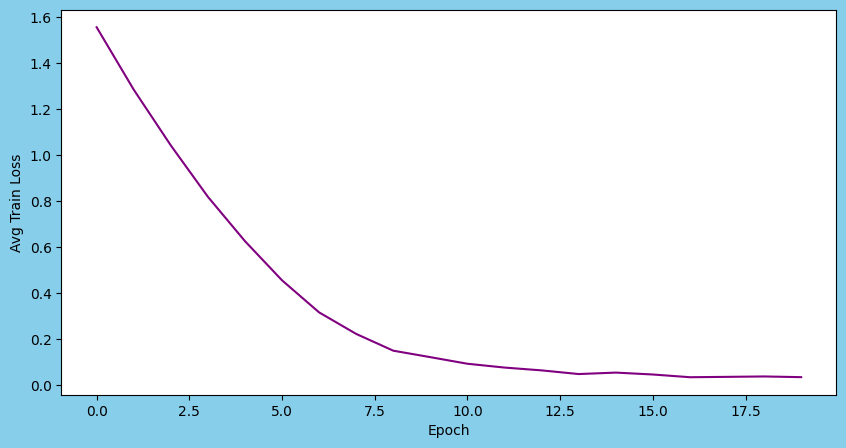

In [229]:
import matplotlib.pyplot as plt
some_figure = plt.figure(figsize = (10,5),facecolor = 'skyblue')
some_ax = some_figure.add_subplot()
some_ax.set_xlabel('Epoch')
some_ax.set_ylabel('Avg Train Loss')
some_ax.plot(results,c = 'purple')

In [266]:
def model_inf(text):
    my_model.eval()
    tokenizer = TrainDataset.tokenizer
    processing = TrainDataset.processing
    main_text = processing(text)
    tokens = tokenizer(
            main_text,
            max_length = TrainDataset.max_length,
            padding = 'max_length',
            return_tensors='pt',
            truncation=True)['input_ids']
    y_pred = my_model(tokens).softmax(dim = 1).argmax(dim = 1).item()
    return label_encoder.classes_[y_pred]

In [269]:
model_inf('Thex exam is pretty well managed. I like it, organisers did a pretty good job')

'Extremely Positive'

In [270]:
model_inf('but I hate everything about this stupid exam')

'Negative'